In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read train and Validation data

In [3]:
# import resources for handling dataset
from utils.LIPDataset import LIPDataset, RandomCrop, RandomHorizontalFlip, Resize, plot_data, ToTensor, Normalize
from torchvision import transforms
import torch




In [4]:
# param to normalize image (expected by pre-trained pytorch model)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
# read dataset and provide augmentation
# TRAIN DATA
train_transform = transforms.Compose([
                Resize((256, 256)),
                RandomCrop((224, 224)),
                RandomHorizontalFlip(),
                ToTensor(),
                Normalize(mean, std, False)
            ])

train_data = LIPDataset('dataset/train_data.ftr', 'dataset/train_set', train_transform)

In [6]:
# resource to display from dataset
from utils.LIPDataset import untransform_n_display

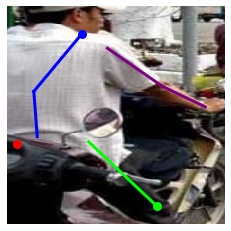

In [15]:
# visualize a sample
untransform_n_display(train_data, 4781 , mean, std, 2)

In [12]:
# VALIDATION DATA
val_transform = transforms.Compose([
                        Resize((224, 224)),
                        ToTensor(),
                        Normalize(mean, std)
                        ])

val_data = LIPDataset('dataset/val_data.ftr', 'dataset/val_set', val_transform)

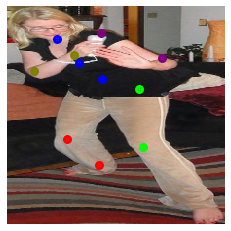

In [14]:
# visualize few sample
untransform_n_display(val_data, 7006, mean, std)

In [10]:
# length of both
len(train_data), len(val_data), train_data[5]['image'].size(), train_data[6]['keypoints'].size()

(30462, 10000, torch.Size([3, 224, 224]), torch.Size([32]))

## Dataloader and batch size

In [10]:
from torch.utils.data import DataLoader

In [11]:
batch_size = 8

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [12]:
samples = next(iter(train_loader))

In [13]:
samples['keypoints'].size() # batches are formed

torch.Size([8, 32])

# Load model. Define lose function and optimizer

In [14]:
from utils.TrainModel import initialize_model

num_keypoints = 16
model = initialize_model(2*num_keypoints) 

In [15]:
model;

In [16]:
# define lose function 
from torch import nn
criterion = nn.MSELoss()


In [17]:
# define optimizer
from torch import optim
optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)

# Training and tracking loss (train + valid)

In [18]:
epoch = 1

# storing loss over whole training
train_loss = list()
valid_loss = list()
# display results 10 times per epoch
prt_freq = 20
num_batches = len(train_loader)
prt_idx = num_batches // prt_freq

# prepare the net for training (autograd, dropout -> on)
model = model.cuda()
model.train()

for i in range(epoch): # looping over whole dataset
    running_loss = 0.0
    # training on batches of data
    for batch_i, samples in enumerate(train_loader):
        # get images and keypoints
        images, keypts = samples['image'].cuda(), samples['keypoints'].cuda()
        # forward pass
        pred = model.forward(images)
        # compute loss
        loss = criterion(pred, keypts)
        # zero the accumulate weight gradients
        optimizer.zero_grad()
        # backward pass (calculate current weight gradients)
        loss.backward()
        # update the weights
        optimizer.step()

        running_loss += loss.item() # storing loss

        # Checking performance on validation data
        # Print all the losses (frequency  is based on prt_freq value)
        if batch_i % prt_idx == 0: 

            temp_loss = 0.0
            with torch.no_grad(): # switching off autograd engine, save memory and computation
                model.eval() # switching off dropout and batchnorm  
                for samples in valid_loader: # looping over batches
                    # get images and keypoints
                    images, keypts = samples['image'].cuda(), samples['keypoints'].cuda()
                    # forward pass
                    pred = model.forward(images)
                    # compute loss
                    loss = criterion(pred, keypts)
                    
                    temp_loss += loss.item()

            avg_train_loss = running_loss/prt_idx
            avg_valid_loss = temp_loss/len(valid_loader)
            print(f'Epoch: {i}, Batch: {batch_i}, Train Avg. Loss: {avg_train_loss}, Validation Avg. Loss:{avg_valid_loss}')
            # storing avg loss for analysis later
            train_loss.append(avg_train_loss)
            valid_loss.append(avg_valid_loss)
            running_loss = 0.0
            model.train() # return to trian mode for next loop

print("Training complete")

Epoch: 0, Batch: 0, Train Avg. Loss: 0.003933580925590114, Validation Avg. Loss:0.6651806684017182
Epoch: 0, Batch: 190, Train Avg. Loss: 0.5143177583029396, Validation Avg. Loss:0.3309324253439903
Epoch: 0, Batch: 380, Train Avg. Loss: 0.473219254769777, Validation Avg. Loss:0.3503163165330887
Epoch: 0, Batch: 570, Train Avg. Loss: 0.4650612147230851, Validation Avg. Loss:0.29494481028318403
Epoch: 0, Batch: 760, Train Avg. Loss: 0.4524740804182856, Validation Avg. Loss:0.28906147429943085
Epoch: 0, Batch: 950, Train Avg. Loss: 0.44379548414757375, Validation Avg. Loss:0.3052421542406082
Epoch: 0, Batch: 1140, Train Avg. Loss: 0.42003903906596335, Validation Avg. Loss:0.27297649672031404
Epoch: 0, Batch: 1330, Train Avg. Loss: 0.42929982527306204, Validation Avg. Loss:0.3357675970673561
Epoch: 0, Batch: 1520, Train Avg. Loss: 0.43405496776103974, Validation Avg. Loss:0.30268653337955476
Epoch: 0, Batch: 1710, Train Avg. Loss: 0.4190199453579752, Validation Avg. Loss:0.2856024269223213

In [19]:
torch.save(model.state_dict(), 'models/state_dict.pt')

## Testing on images

In [32]:
model.load_state_dict(torch.load('models/state_dict.pt'))

<All keys matched successfully>

In [54]:
from utils.TrainModel import random_test

In [58]:
%timeit sample, pred_pts = random_test(val_data, model, [mean, std], display=False)

256 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
# display actual 
# untransform_n_display([{'image':image, 'keypoints':actual_pts}], 0, mean, std)